In [1]:
from utitlity_functions import *
import numpy as np
from confectionery import Confectionery
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import scienceplots
import cv2 as cv
from matplotlib import cm
from scipy.spatial.transform import Rotation as R
from particle_data_structure import ParticleDataStruct
from cluster_half_shelfs_alpha import Half_shelf_cluster
from cluster_to_edge_pixel import contour_edge
np.random.seed(137)

In [2]:
number_objs=3
objs=[np.load("data/obj_traj_"+str(i)+".npy") for i in range(number_objs)]
normal_vector_trajectory=[np.load("data/normal_vector_trajectory_"+str(i)+".npy") for i in range(number_objs)]
rotation_trajectory=[np.load("data/rotation_trajectory_as_rotvec_"+str(i)+".npy") for i in range(number_objs)]
stream_string=np.load("data/stream_string.npy")
particle_structured3d_path="data/particle_structured3d_"
particle_structured_flat_path="data/particle_structured_flat_"
koppenrath=Confectionery()
cut_radius=11


In [3]:
structured_datas=[ParticleDataStruct(x,stream_string,koppenrath) for x in objs]
particle_datas_3d=[np.load(particle_structured3d_path+str(i)+".npy")for i in range(number_objs)]
particle_datas_flat=[np.load(particle_structured_flat_path+str(i)+".npy") for i in range(number_objs)]
particle_datas_flat_effective=[x.get_data_flatten_effective(cut_radius,y) for x,y in zip(structured_datas,particle_datas_flat)]

In [4]:
half_shelf_clusters=[Half_shelf_cluster(objs, stream_string, confectionery=koppenrath,cut_radius=cut_radius) for x in objs]
for i in range(number_objs):
    half_shelf_clusters[i].load_data_from_np_array(particle_datas_flat_effective[i].flatten())

In [5]:
objects_clustered=[]
for i in range(number_objs):
    label=half_shelf_clusters[i].label(particle_datas_flat_effective[i].flatten(),method="GMM")
    label=label+1
    label_flat_effective=label.reshape(particle_datas_flat_effective[i].shape)
    label_flat=structured_datas[i].data_flatten_effective_to_data_flat(cut_radius,label_flat_effective)
    objects_clustered.append(structured_datas[i].expand_data(label_flat))


In [6]:
edge_pixels_locals=[]
edge_pixels_global=[]
for i in range(number_objs):
    edge_pixels_local_trajectory=[]
    edge_object=contour_edge(objects_clustered[i], cut_radius=cut_radius, confectionery=koppenrath)
    edge_object.compute_edges()
    edge_pixels=edge_object.edge_pixels
    edge_pixels_global.append(edge_pixels)
    radius=round(np.mean(objs[i][:,-1]))
    center=np.array([radius,radius]).reshape((1,2))
    for i in range(particle_datas_3d[i].shape[0]):
        edge_pixels_local=edge_pixels[i][:,:-1]-center
        z=-np.sqrt(radius**2-np.sum(edge_pixels_local**2,axis=1).reshape((-1,1)))
        edge_pixels_3d_local=np.concatenate((edge_pixels_local,z),axis=1)
        edge_pixels_local_trajectory.append(edge_pixels_3d_local)
    edge_pixels_locals.append(edge_pixels_local_trajectory)

# visualize contour estimation results

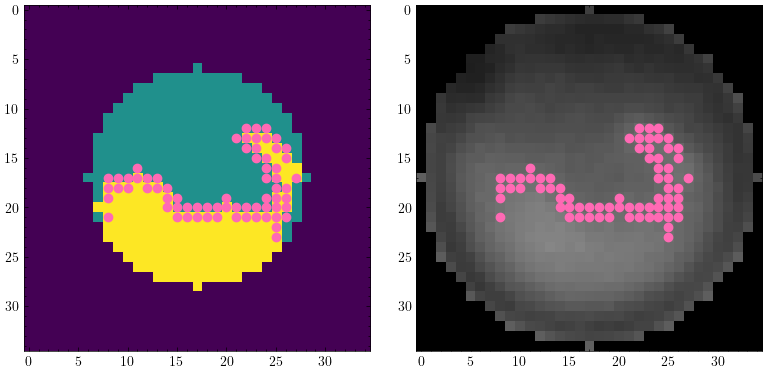

In [7]:
t=10
obj_number=1
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [8, 8]
    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.tight_layout()
    ax1.imshow(objects_clustered[obj_number][t,:,:])
    ax1.scatter(edge_pixels_global[obj_number][t][:,0],edge_pixels_global[obj_number][t][:,1], color="hotpink")
    ax2.imshow(particle_datas_3d[obj_number][t,:,:],vmin=0,vmax=255,cmap="grey")
    ax2.scatter(edge_pixels_global[obj_number][t][:,0],edge_pixels_global[obj_number][t][:,1], color="hotpink")
    plt.show()

# get window around contour

In [8]:
N=edge_pixels_global[obj_number][t].shape[0]
window_length=3
X=[particle_datas_3d[obj_number][t,x[1]-1:x[1]+2,x[0]-1:x[0]+2].flatten() for x in edge_pixels_global[obj_number][t]]
X=np.array(X)
X_mean=np.mean(X,axis=1)
X_var=np.sum(((X-X_mean[:,np.newaxis])**2),axis=1)/(window_length**2-1)


# Show filtered out border pixels

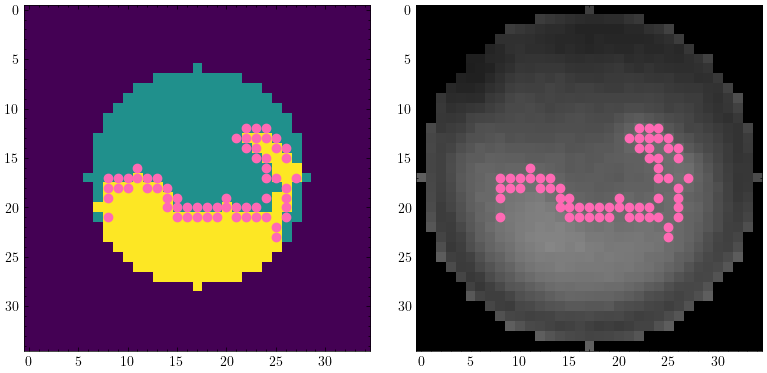

In [9]:
thres_var=10
t=10
obj_number=1
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [8, 8]
    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.tight_layout()
    ax1.imshow(objects_clustered[obj_number][t,:,:])
    ax1.scatter(edge_pixels_global[obj_number][t][X_var>thres_var,0],edge_pixels_global[obj_number][t][X_var>thres_var,1], color="hotpink")
    ax2.imshow(particle_datas_3d[obj_number][t,:,:],vmin=0,vmax=255,cmap="grey")
    ax2.scatter(edge_pixels_global[obj_number][t][X_var>thres_var,0],edge_pixels_global[obj_number][t][X_var>thres_var,1], color="hotpink")
    plt.show()

In [10]:
X=X[X_var>thres_var,:]
X_mean=X_mean[X_var>thres_var]
X_var=X_var[X_var>thres_var]
X_norm=(X-X_mean[:,np.newaxis])/np.sqrt(X_var[:,np.newaxis])


In [11]:
print(len(edge_pixels_locals[1]))
print(len((edge_pixels_global[1])))

987
987


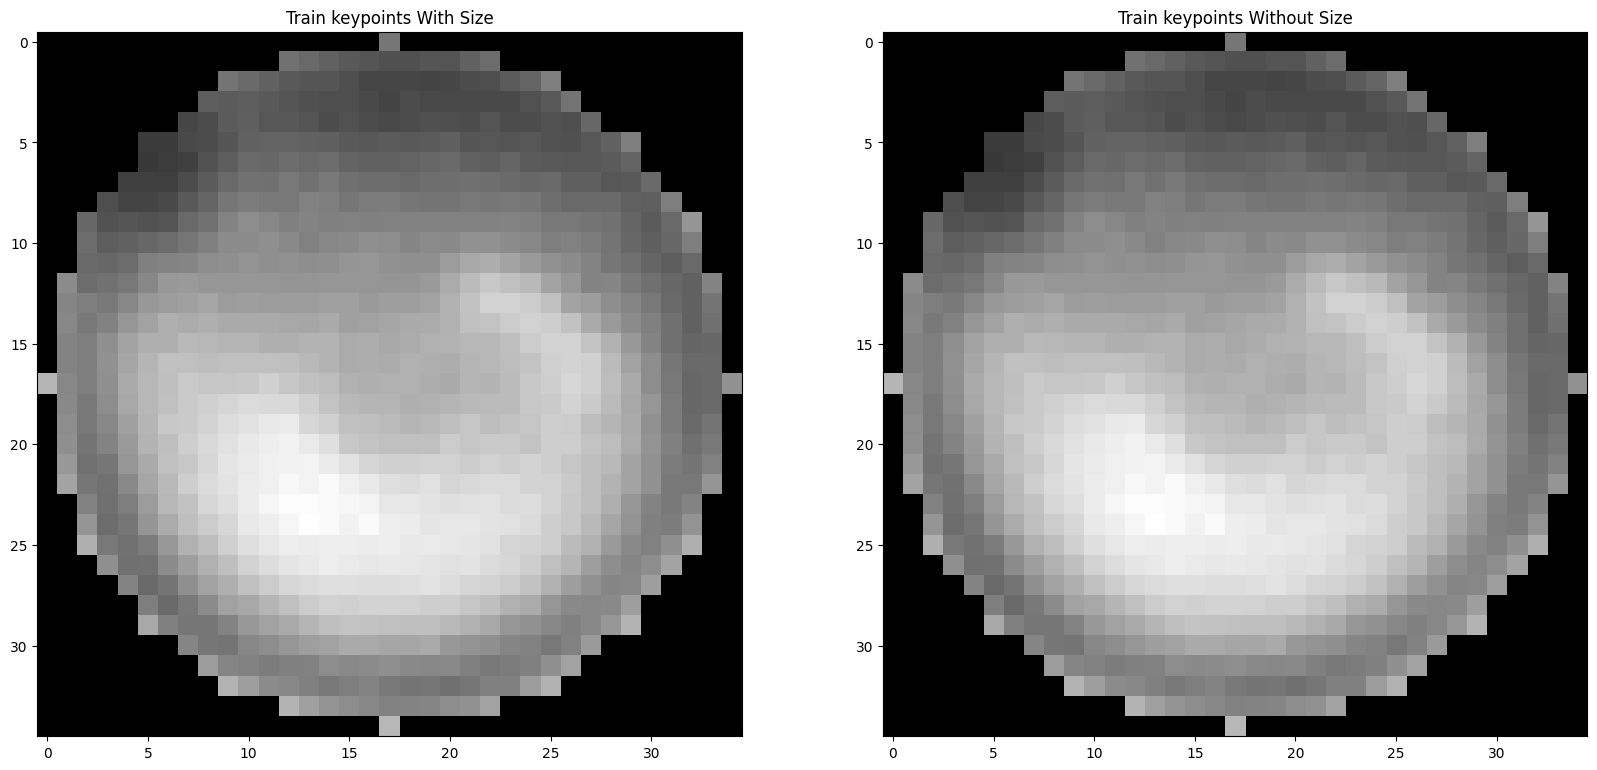

Number of Keypoints Detected In The Training Image:  1


In [12]:
sift = cv.SIFT_create()
gray=particle_datas_3d[obj_number][t,:,:].astype(np.uint8)
train_keypoints, train_descriptor = sift.detectAndCompute(gray, None)
training_image=gray
keypoints_without_size = np.copy(training_image)
keypoints_with_size = np.copy(training_image)

cv.drawKeypoints(training_image, train_keypoints, keypoints_without_size, color = (0, 255, 0))

cv.drawKeypoints(training_image, train_keypoints, keypoints_with_size, flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without keypoints size
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size, cmap='gray')
plt.show()
# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))




In [14]:
print(train_keypoints)

(< cv2.KeyPoint 0x16beef300>,)
